In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd


In [2]:
vec_1 = pd.read_csv(f"/content/drive/MyDrive/мага 1 сем/electronic_vec.tsv",delimiter='\t',header=None).iloc[:,1:]
vec_2 = pd.read_csv(f"/content/drive/MyDrive/мага 1 сем/med_vec.tsv",delimiter='\t',header=None).iloc[:,1:]
vec_3 = pd.read_csv(f"/content/drive/MyDrive/мага 1 сем/space_vec.tsv",delimiter='\t',header=None).iloc[:,1:]


In [3]:
import numpy as np
vec_1['target'] = np.ones(len(vec_1)) * 0
vec_2['target'] = np.ones(len(vec_2)) * 1
vec_3['target'] = np.ones(len(vec_3)) * 2

In [ ]:
vec_1

In [4]:
from sklearn.model_selection import train_test_split
train_1, test_1 = train_test_split(vec_1, test_size=0.2, random_state=42)
train_2, test_2 = train_test_split(vec_2, test_size=0.2, random_state=42)
train_3, test_3 = train_test_split(vec_3, test_size=0.2, random_state=42)

train_set = pd.concat([train_1, train_2, train_3], ignore_index=True)
test_set = pd.concat([test_1, test_2, test_3], ignore_index=True)

In [5]:
X_train = train_set.drop(columns = 'target')
X_test = test_set.drop(columns = 'target')
y_train = train_set['target']
y_test = test_set['target']

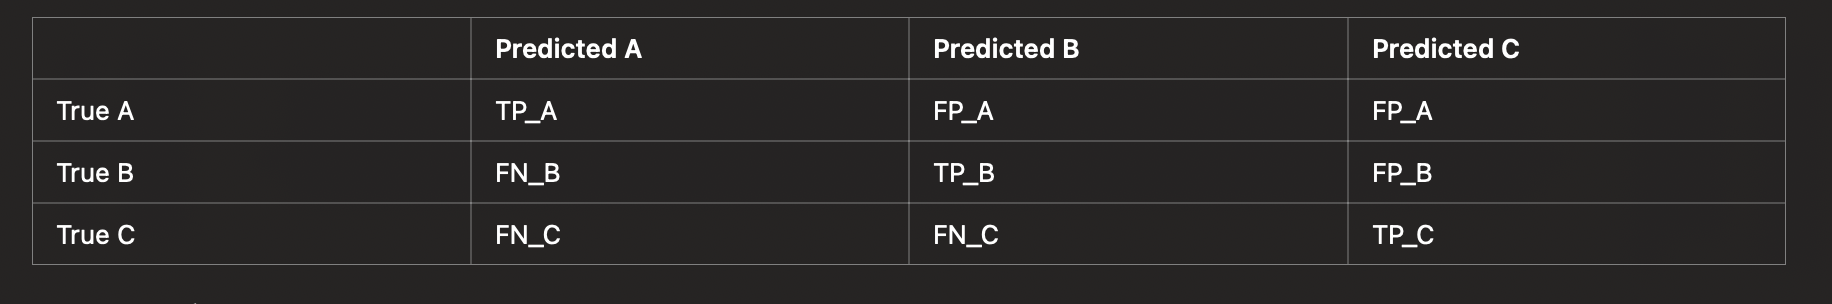

In [46]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (TP + TN) / (TP + FP + FN + TN)

    return np.nanmean(precision), np.nanmean(recall), np.nanmean(f1_score), np.nanmean(accuracy)

In [ ]:
from sklearn.svm import SVC
import time
def train_svm_with_kernels(X_train, X_test, y_train, y_test):
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    results = []

    for kernel in kernels:
        model = SVC(kernel=kernel, max_iter=1000)
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time

        y_pred = model.predict(X_test)
        precision, recall, f1, accuracy = calculate_metrics(y_test, y_pred)

        results.append({
            'kernel': kernel,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'accuracy': accuracy,
            'training_time': training_time
        })
    return results
results = train_svm_with_kernels(X_train, X_test, y_train, y_test)

In [ ]:
pd.DataFrame(results)

ф1 самый высокий у linear

	•	linear — если классы можно разделить линейно.
	•	poly — если данные требуют полиномиального разделения.
	•	rbf — для сложных и нелинейных данных, обычно наиболее эффективный выбор.
	•	sigmoid — редко используется, но может быть полезен для экспериментов с задачами, напоминающими нейронные сети.

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import time
from sklearn.preprocessing import FunctionTransformer

def reduce_dimensions_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

def add_features(X_train, X_test):
    transformer_log = FunctionTransformer(np.log1p, validate=True)
    transformer_sin = FunctionTransformer(np.sin, validate=True)

    X_train_log = transformer_log.transform(X_train)

    print(X_train_log.shape)
    X_test_log = transformer_log.transform(X_test)

    X_train_sin = transformer_sin.transform(X_train)
    X_test_sin = transformer_sin.transform(X_test)


    X_train_new = np.hstack([X_train, X_train_log, X_train_sin])
    X_test_new = np.hstack([X_test, X_test_log, X_test_sin ])

    print(X_train_new.shape)
    return X_train_new, X_test_new


def preprocess_data(X_train, X_test):
    imputer = SimpleImputer(strategy='mean')

    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    return X_train_imputed, X_test_imputed


def run_experiment(X_train, X_test, y_train, y_test, pca_components):
    X_train_pca, X_test_pca = reduce_dimensions_pca(X_train, X_test, pca_components)

    pca_results = train_svm_with_kernels(X_train_pca, X_test_pca, y_train, y_test)


    X_train_new, X_test_new = add_features(X_train, X_test)
    X_train_new, X_test_new = preprocess_data(X_train_new, X_test_new)

    feature_results = train_svm_with_kernels(X_train_new, X_test_new, y_train, y_test)

    return pca_results, feature_results


pca_components = 90
pca_results, feature_results = run_experiment(X_train, X_test, y_train, y_test, pca_components)
print("как было:")
print(pd.DataFrame(results))
print("с PCA:")
print(pd.DataFrame(pca_results))

print(" с новыми признаками:")
print(pd.DataFrame(feature_results))
